In [1433]:
import numpy as np
import tarfile
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns


# Important for the import of cifar 10
import sys
sys.path.append("../")
from dataloader import load_cifar10
from dataloader import load_mnist



#### **The point of this notebook, is to show the progress of building a FFN from sratch, that means each section will add a new functionality, so it will become a step-by-step progress. We have derived formulas and ideas in each section aswell**

# Section 1: Dataloading + one-hot

### Load the cifar-10

In [1434]:
# Load CIFAR-10
#X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("../data/cifar-10-python.tar.gz")
# Load MNIST
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist("/workspaces/02456-deep-learning/data/mnist")

### THE SHAPE OF CIFAR IS:    (RxGxB = 3) x 32 x 32       x      (no. pictures)

Train set: (54000, 1, 28, 28) (54000,)
Validation set: (6000, 1, 28, 28) (6000,)
Test set: (10000, 1, 28, 28) (10000,)


In [1435]:
X_flat = X_train.reshape(X_train.shape[0], -1)  # (54000, 784)
X_flat = X_flat 
X_flat.shape

(54000, 784)

So the input for each picture will be: 1 * 28 * 28 = 784

In [1436]:
X_train[0].shape

(1, 28, 28)

In [1437]:
ex = X_train[0].flatten()
ex.shape

(784,)

> Perform one hot encoding on the training labels

In [1438]:

num_classes = y_train.max() + 1

# Convert to one-hot encoding
y_train_onehot = np.eye(num_classes)[y_train]

print(y_train_onehot[0], y_train[0])


[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 6


# Section 2: FFN

> ### Forward method of layer 

In [1439]:
def activation(activationName, Z):
    if activationName == "RELU":
        return np.maximum(0, Z)
    
    if activationName == "Softmax":
        # x: (batch_size, n_classes)
        x_shifted = Z - np.max(Z, axis=-1, keepdims=True)
        e_x = np.exp(x_shifted)
        return e_x / e_x.sum(axis=-1, keepdims=True)

def activation_derivative(activationName, Z):
    if activationName == "RELU":
        return (Z > 0).astype(float)  # 1 where Z > 0, else 0
    # add more derivatives if needed


In [1440]:
class Layer:
    def __init__(self, input_dim, output_dim, activation = "RELU"):
        print(f'Layer with input_dim: {input_dim}, output dim, {output_dim}')
        self.inp = input_dim
        self.out = output_dim
        self.activation = activation

        self.a = None
        self.z = None
        
        #HE init of weights (refer to lecture notes)
        self.W = np.random.randn(output_dim, input_dim) * np.sqrt(2 / input_dim)
        self.b = np.zeros(output_dim)  

    
    #This forward will either calculate for a single vector (z) or a batch
    def forward(self, z):
        # z can be (input_dim,) or (batch_size, input_dim)
        if z.ndim == 1:
            self.a = self.W @ z + self.b
        else:
            self.a = z @ self.W.T + self.b  # batch forward
        self.z = activation(self.activation, self.a)
        return self.z


In [1441]:
layer1 = Layer(784, 15, "RELU")
output = Layer(15, 10, "Softmax")

layer1.forward(X_flat)
output.forward(layer1.z)

output.z[1]



Layer with input_dim: 784, output dim, 15
Layer with input_dim: 15, output dim, 10


array([1.57008414e-108, 2.97280935e-123, 3.06163905e-175, 9.99999996e-001,
       1.26697188e-214, 6.31081518e-059, 1.04645255e-112, 4.85711669e-108,
       3.84119188e-009, 3.81056810e-025])

In [1442]:
output.z

array([[2.10118192e-068, 2.49912182e-134, 3.39637261e-087, ...,
        8.43281655e-065, 2.75410843e-043, 3.94108824e-037],
       [1.57008414e-108, 2.97280935e-123, 3.06163905e-175, ...,
        4.85711669e-108, 3.84119188e-009, 3.81056810e-025],
       [4.25462340e-006, 2.44917900e-069, 4.13370903e-183, ...,
        7.02671888e-058, 6.39330370e-048, 2.04972702e-029],
       ...,
       [2.42166005e-088, 5.44552334e-245, 1.29506265e-220, ...,
        2.14147236e-149, 4.02649274e-072, 1.00000000e+000],
       [2.19173478e-057, 1.51458558e-057, 1.35091175e-107, ...,
        2.12841428e-032, 2.24108121e-057, 7.80846641e-056],
       [2.25363329e-023, 2.32524224e-032, 2.14889249e-046, ...,
        9.99997356e-001, 4.26714922e-022, 2.63883038e-006]],
      shape=(54000, 10))

> ### Forward method of layer + loss 

We are not getting a output, we are purely working with multi-class classfication, therefore we will use cross-entropy as a loss function. In order for us to calculate cross entropy loss

1. We are getting a probability density as output
2. onehot(score) gives a 10 x [0,0,0,0,0,1,0,0] of different combinations depending on label
3. We then say loss(onehot(score), y_true) for each output

> Source :  https://medium.com/@naqvishahwar120/ai-using-cross-entropy-loss-function-and-one-hot-encoding-4a102a1253dc

We will be implementing cross entropy (numerical stable version from lecture)

In [1443]:
loss = -np.sum(y_train_onehot * np.log(output.z)) / y_train_onehot.shape[0]

print("Cross Entropy Loss:", loss)

Cross Entropy Loss: nan


/tmp/ipykernel_1244/2274831616.py:1: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(y_train_onehot * np.log(output.z)) / y_train_onehot.shape[0]
/tmp/ipykernel_1244/2274831616.py:1: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(y_train_onehot * np.log(output.z)) / y_train_onehot.shape[0]


> ### Forward method of layer + loss + Manual backpropagation

1. We are working with multi-classification, so the only last layer activation function will be softmax
2. We want to be able to use cross-entropy loss function

>Source: https://www.parasdahal.com/softmax-crossentropy

>Source: https://www.kaggle.com/code/ravaghi/neural-networks-from-scratch-using-only-numpy

> Overall method : Calcuate output gradient using Softmax / Cross entropy





#### 1. Output layer

The output logits:

$$
o_k = \sum_i w^{(L)}_{ki}\, z^{(L-1)}_i + b^{(L)}_k
$$

Softmax probabilities:

$$
p_i = \frac{e^{o_i}}{\sum_k e^{o_k}}
$$

Cross-entropy loss:

$$
L(\mathbf{y}, \mathbf{p}) = - \sum_k y_k \log(p_k)
$$

Derivative of softmax + cross-entropy:

$$
\frac{\partial L}{\partial o_i} = p_i - y_i
$$

Define the **output delta**:

$$
\delta^{(L)}_i = p_i - y_i
$$

Weight and bias gradients:

$$
\frac{\partial L}{\partial w^{(L)}_{ji}} = \delta^{(L)}_j \, z^{(L-1)}_i, 
\qquad
\frac{\partial L}{\partial b^{(L)}_j} = \delta^{(L)}_j
$$

---

#### 2. Hidden layers (l = L-1, ..., 1)

For hidden layer \(l\) with pre-activation \(a^{(l)}_j\) and post-activation \(z^{(l)}_j = h_l(a^{(l)}_j)\):

Hidden delta:

$$
\delta^{(l)}_j = h_l'(a^{(l)}_j) \sum_{k=1}^{K_{l+1}} w^{(l+1)}_{kj} \, \delta^{(l+1)}_k
$$

Weight and bias gradients:

$$
\frac{\partial L}{\partial w^{(l)}_{ji}} = \delta^{(l)}_j \, z^{(l-1)}_i, 
\qquad
\frac{\partial L}{\partial b^{(l)}_j} = \delta^{(l)}_j
$$


#### 3. Summary table

$$
\begin{align}
\text{Output layer:} \quad & 
\frac{\partial L}{\partial w^{(L)}_{ji}} = \delta^{(L)}_j \, z^{(L-1)}_i, \quad
\frac{\partial L}{\partial b^{(L)}_j} = \delta^{(L)}_j, \quad
\delta^{(L)}_j = p_j - y_j \\
\text{Hidden layer:} \quad & 
\frac{\partial L}{\partial w^{(l)}_{ji}} = \delta^{(l)}_j \, z^{(l-1)}_i, \quad
\frac{\partial L}{\partial b^{(l)}_j} = \delta^{(l)}_j, \quad
\delta^{(l)}_j = h_l'(a^{(l)}_j) \sum_{k=1}^{K_{l+1}} w^{(l+1)}_{kj} \, \delta^{(l+1)}_k
\end{align}
$$




Manual backprop of 2 layer FFN

In [1444]:
output.z[0]
print("Cross Entropy Loss before gradient descent:", loss)

Cross Entropy Loss before gradient descent: nan


In [1445]:

loss_list = []
accuracy_list = []

for i in range(1):
    m = X_flat.shape[0]

    # Output layer
    deltaL = output.z - y_train_onehot
    dW2 = layer1.z.T @ deltaL / m
    db2 = np.sum(deltaL, axis=0) / m
    dW2[0], db2[0]

    # Hidden layer (input layer)
    deltaLm1 = deltaL @ output.W * activation_derivative("RELU", layer1.a)
    dW1 = X_flat.T @ deltaLm1 / m
    db1 = np.sum(deltaLm1, axis=0) / m
    dW1[0], db1[0]

    layer1.W -= 0.01 * dW1.T
    layer1.b -= 0.01 * db1

    output.W -= 0.01 * dW2.T
    output.b -= 0.01 * db2

    layer1.forward(X_flat)
    output.forward(layer1.z)
    output.z[0]

    loss = -np.sum(y_train_onehot * np.log(output.z)) / y_train_onehot.shape[0]
        
    #METRICS
    loss_list.append(loss)

    # ---------- Compute accuracy ----------
    y_pred = np.argmax(output.z, axis=1)              
    y_true = np.argmax(y_train_onehot, axis=1)
    acc = np.mean(y_pred == y_true)
    accuracy_list.append(acc)

print("Cross Entropy Loss after gradient descent:", loss)

Cross Entropy Loss after gradient descent: nan


/tmp/ipykernel_1244/1192783709.py:29: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(y_train_onehot * np.log(output.z)) / y_train_onehot.shape[0]
/tmp/ipykernel_1244/1192783709.py:29: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(y_train_onehot * np.log(output.z)) / y_train_onehot.shape[0]


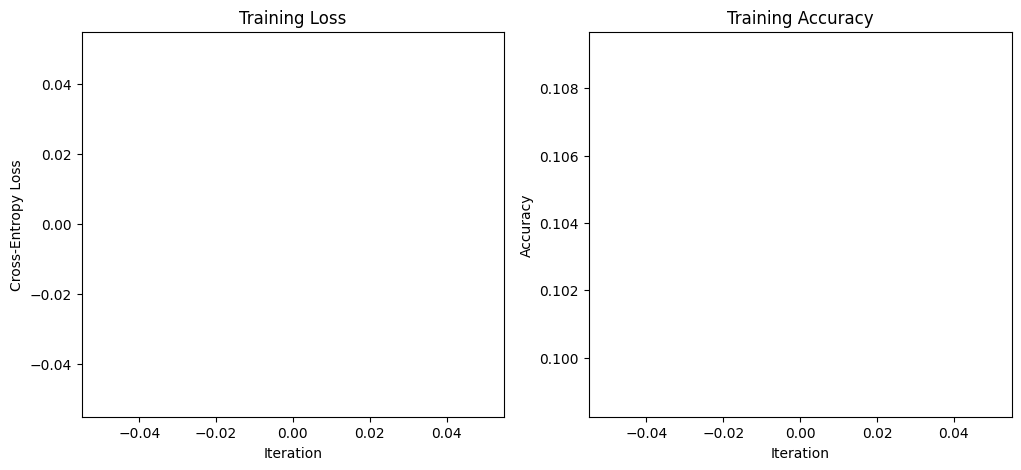

Final Loss: nan
Final Accuracy: 0.10396296296296297


In [1446]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training Loss')

plt.subplot(1,2,2)
plt.plot(accuracy_list)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.show()

print("Final Loss:", loss_list[-1])
print("Final Accuracy:", accuracy_list[-1])

> **Part conclusion** We are able to see that the cross-entropy-loss is decreasing as we run the gradients and forward measures again, again and again, therefore we can create a loop for this. (called backprop). This will perform the gradient descent

> ### Forward method of layer + loss + modular backpropagation

This will be a VERY simple NN architecture, in which we will build upon. 

In [1447]:
def activation(activationName, Z):
    if activationName == "RELU":
        return np.maximum(0, Z)
    
    if activationName == "Softmax":
        # x: (batch_size, n_classes)
        x_shifted = Z - np.max(Z, axis=-1, keepdims=True)
        e_x = np.exp(x_shifted)
        return e_x / e_x.sum(axis=-1, keepdims=True)

def activation_derivative(activationName, Z):
    if activationName == "RELU":
        return (Z > 0).astype(float)  # 1 where Z > 0, else 0
    # add more derivatives if needed


In [ ]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []
        self.loss = None

    def returnLoss(self, y_onehot):
        if self.loss == "cross":
            return -np.sum(y_onehot * np.log(self.layers[-1].z)) / y_onehot.shape[0]

    def linearLayer(self, input_dim, output_dim, activation = "RELU"):
        self.layers.append(Layer(input_dim, output_dim, activation))

    def Forward(self, input):
        #First we calculate the input 
        self.layers[0].forward(input)

        #Then we use the input z, to calculte subsquent layers
        for i in range(1, len(self.layers)):
            self.layers[i].forward(self.layers[i-1].z)

        #Output the output after softmax, this will be a distribution
        print(self.layers[-1].z[0])

    def backward(self,X_train, y_train_onehot):
        #Used to find average in batching
        m = X_train.shape[0]
        last_layer = self.layers[-1]
        
        if loss == "cross":
            delta = last_layer.z - y_train_onehot  # shape: (m, num_classes)

                #Start from the end and go down
                for i in range(len(reversed(self.layers))):

                    

In [1449]:
class Layer:
    def __init__(self, input_dim, output_dim, activation = "RELU"):
        print(f'Layer with input_dim: {input_dim}, output dim, {output_dim}')
        self.inp = input_dim
        self.out = output_dim
        self.activation = activation

        self.a = None
        self.z = None
        
        #HE init of weights (refer to lecture notes)
        self.W = np.random.randn(output_dim, input_dim) * np.sqrt(2 / input_dim)
        self.b = np.zeros(output_dim)  
        
        #These must be zero at intialization, but during back propagation we update them
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
    
    #This forward will either calculate for a single vector (z) or a batch
    def forward(self, z):
        # z can be (input_dim,) or (batch_size, input_dim)
        if z.ndim == 1:
            self.a = self.W @ z + self.b
        else:
            self.a = z @ self.W.T + self.b  # batch forward
        self.z = activation(self.activation, self.a)
        return self.z


In [ ]:
#Pipeline will be as following

#Create the NN class, which takes care of forward, backward, losss etc
nn = NeuralNetwork()

#Architecture
nn.linearLayer(784, 15, "RELU")
nn.linearLayer(15, 15, "RELU")
nn.linearLayer(15, 10, "Softmax")

#Forward measure
nn.Forward(X_flat)  # (batch_size, 10)

#Loss function
nn.loss="cross"
nn.returnLoss(y_train_onehot)

#Find gradients, using backwards
nn.backward(X_flat, y_train_onehot)  




Layer with input_dim: 784, output dim, 15
Layer with input_dim: 15, output dim, 15
Layer with input_dim: 15, output dim, 10


[1.36220029e-082 6.66243392e-009 1.79759878e-118 6.25174189e-086
 1.05977921e-013 2.94465437e-050 1.68988697e-057 9.46048293e-062
 1.28813071e-014 9.99999993e-001]


np.float64(118.44617744002967)

___

# Draft

In [1451]:
import numpy as np
from typing import List, Optional, Tuple, Union

# --------------------
# Activations
# --------------------
def sigmoid(Z):
    return 1.0 / (1.0 + np.exp(-Z))

def sigmoid_prime(Z):
    s = sigmoid(Z)
    return s * (1 - s)

def relu(Z):
    return np.maximum(0, Z)

def relu_prime(Z):
    return (Z > 0).astype(float)

def tanh(Z):
    return np.tanh(Z)

def tanh_prime(Z):
    return 1 - np.tanh(Z)**2

def softmax(Z):
    Zc = Z - np.max(Z, axis=0, keepdims=True)
    expZ = np.exp(Zc)
    return expZ / np.sum(expZ, axis=0, keepdims=True)

# map activation name to function/derivative
_ACTIVATIONS = {
    'sigmoid': (sigmoid, sigmoid_prime),
    'relu':    (relu, relu_prime),
    'tanh':    (tanh, tanh_prime),
    'softmax': (softmax, None)  # softmax derivative handled together with CE loss
}

# --------------------
# Initializer
# --------------------
class initializer:
    @staticmethod
    def init_weights(n_in: int, n_out: int, act_fn: str):
        # He for ReLU, Xavier for tanh/sigmoid/softmax
        if act_fn == 'relu':
            return np.random.randn(n_out, n_in) * np.sqrt(2.0 / n_in)
        else:
            # Xavier/Glorot
            return np.random.randn(n_out, n_in) * np.sqrt(1.0 / n_in)

    @staticmethod
    def init_bias(n_out: int):
        return np.zeros((n_out, 1))


# --------------------
# Utilities
# --------------------
def to_one_hot(y: np.ndarray, num_classes: int) -> np.ndarray:
    """
    y: shape (m,) with integer labels [0..num_classes-1]
    returns: (num_classes, m)
    """
    m = y.shape[0]
    Y = np.zeros((num_classes, m))
    Y[y, np.arange(m)] = 1
    return Y



In [1452]:

# --------------------
# Layer (fully connected)
# --------------------
class Layer:
    def __init__(self, n_in: int, n_out: int, act_fn: str = 'relu'):
        assert act_fn in _ACTIVATIONS, f"Unsupported activation '{act_fn}'"
        self.n_in = n_in
        self.n_out = n_out
        self.act_name = act_fn
        self.act, self.act_prime = _ACTIVATIONS[act_fn]

        # parameters
        self.W = initializer.init_weights(n_in, n_out, act_fn)
        self.b = initializer.init_bias(n_out)


    def forward(self, A_prev: np.ndarray) -> np.ndarray:
        """
        A_prev: (n_in, m)
        returns A: (n_out, m)
        """
        self.Z = np.dot(self.W, A_prev) + self.b  # (n_out, m)
        if self.act_name == 'softmax':
            self.A = self.act(self.Z)
        else:
            self.A = self.act(self.Z)
        return self.A



In [1453]:

# --------------------
# Neural Network
# --------------------
class NeuralNetwork:
    def __init__(self):
        self.layers: List[Layer] = []

    def add_layer(self, n_in: int, n_out: int, act_fn: str = 'relu'):
        """
        Add a fully-connected layer. Provide n_in for the layer.
        (n_in must match previous layer's n_out if stacking.)
        """
        layer = Layer(n_in, n_out, act_fn)
        self.layers.append(layer)

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        X: (n_x, m)
        returns A_last: (n_last, m)
        """
        A = X
        for layer in self.layers:
            A = layer.forward(A)
        return A


# --------------------
# Example usage with flattened image input (e.g. CIFAR-10: 32*32*3 = 3072)
# --------------------
if __name__ == "__main__":
    # --- load CIFAR-10 (you provided this) ---
    # X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("../data/cifar-10-python.tar.gz")
    # For this example we assume the above line executed already and variables exist.

    # Quick helper to convert many possible CIFAR shapes into (n_features, m)
    def prepare_X_for_forward(X):
        """
        Returns X_proc with shape (n_features, m)
        Accepts:
          - (3,32,32,m)
          - (m,3,32,32)
          - (m,32,32,3)
          - (m, 3072)
        """
        X = np.asarray(X)
        if X.ndim == 4:
            # Case: (3,32,32,m)
            if X.shape[0] == 3 and X.shape[1] == 32 and X.shape[2] == 32:
                # reorder to (m, 3, 32, 32)
                X = np.transpose(X, (3, 0, 1, 2))
            # Now possible shapes: (m, 3, 32, 32) or (m, 32, 32, 3)
            m = X.shape[0]
            if X.shape[1] == 3 and X.shape[2] == 32 and X.shape[3] == 32:
                # channels-first (m,3,32,32)
                X_flat = X.reshape(m, -1)   # (m, 3072)
            elif X.shape[1] == 32 and X.shape[2] == 32 and X.shape[3] == 3:
                # channels-last (m,32,32,3)
                X_flat = X.reshape(m, -1)
            else:
                raise ValueError(f"Unrecognized 4D shape: {X.shape}")
        elif X.ndim == 2:
            # Already flattened e.g. (m, 3072) or (3072, m)
            if X.shape[1] == 3072:
                X_flat = X
            elif X.shape[0] == 3072:
                # already (3072, m) — transpose to (m,3072) for consistency below
                X_flat = X.T
            else:
                raise ValueError(f"Unrecognized 2D shape: {X.shape}")
        else:
            raise ValueError(f"Unrecognized X ndim: {X.ndim}")

        # Produce (n_features, m)
        X_proc = X_flat.T  # now (3072, m)
        return X_proc

    # ---- prepare data ----
    # Use a small batch for demo to save memory/time
    # (you can swap in the full X_train if you want)
    # Example: take first 128 train examples (if present)
    num_examples = 128
    try:
        X_sample = X_train[:num_examples]
    except NameError:
        raise RuntimeError("X_train not found. Make sure you ran load_cifar10() before this script.")

    X_proc = prepare_X_for_forward(X_sample)   # shape (3072, m_sample)
    print("Prepared X_proc shape (features, m):", X_proc.shape)

    # ---- build a small FFN ----
    nn = NeuralNetwork()
    # Input layer must match flattened size 3072
    nn.add_layer(3072, 512, act_fn='relu')
    nn.add_layer(512, 256, act_fn='relu')
    # Final layer for CIFAR-10 multiclass -> softmax with 10 outputs
    nn.add_layer(256, 10, act_fn='softmax')

    # ---- forward pass only ----
    A_last = nn.forward(X_proc)   # shape (10, m_sample)
    print("A_last shape (n_out, m):", A_last.shape)

    # If softmax final layer, show probabilities and predictions for first few examples
    if nn.layers[-1].act_name == 'softmax':
        probs = A_last  # already probabilities
        preds = np.argmax(probs, axis=0)  # (m,)
        print("First 6 predicted labels:", preds[:6])
        print("First example softmax probs (first 10 classes):")
        print(probs[:, 0])   # full vector of 10 probs for example 0
    else:
        # For binary output
        print("First 6 outputs (sigmoid):", A_last[:, :6])


ValueError: Unrecognized 4D shape: (128, 1, 28, 28)

# Section 3: Loss / Backpropgation